# Example: Convolutional Fit

This notebook demonstrates how to convolve a distribution with a resolution function using fitle. This technique is commonly used in particle physics to convolve QED-based radiative predictions (e.g., from PHOTOS simulations) with detector resolution functions.

In [1]:
import fitle as fl
import numpy as np
import matplotlib.pyplot as plt
import operator

## Mathematical Background

The discrete convolution approximation is:

$$
(Q \star R)(x) \approx \sum_{n=0}^{n_{\text{bins}} - 1} Q(x'_n) \, R(x - x'_n) \, \Delta x'_n
$$

where:
- $Q$ denotes the radiative distribution (e.g., from simulation)
- $R$ is the resolution function (e.g., a Gaussian)
- $x'_n$ are the bin centers of the input histogram
- $\Delta x'_n$ are the bin widths

## Implementation in Fitle

The built-in `convolve` function is functionally equivalent to:

```python
def convolve(centers, counts, mass_mother, mu, sigma, idx=None):
    n = index(len(counts)) if not idx else idx
    Qx_n = indecise(counts, n)
    x_n = indecise(centers, n)
    shifted_x = fl.INPUT + mass_mother - mu
    R = gaussian(mu=x_n, sigma=sigma) % shifted_x
    weighted = Qx_n * R
    ret = Reduction(weighted, n, operator.add)
    Xi = indecise(INPUT)
    return ret / ((Xi[1]-Xi[0]) * np.sum(ret))
```

Key concepts:
- `index(len(counts))` creates an index parameter `n` with a range
- `indecise(arr, n)` creates a Model that selects the nth element of an array
- The `%` operator substitutes `INPUT` with the shifted value
- `Reduction(weighted, n, operator.add)` sums over the index parameter

## Generate a Simulated Distribution

Let's create a simulated "PHOTOS-like" histogram representing a radiative distribution.

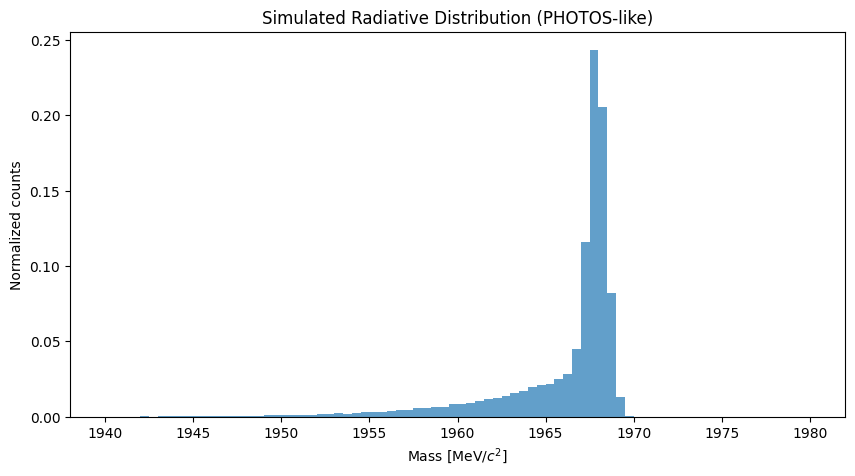

In [2]:
# Create a simulated radiative distribution (asymmetric, like a radiative tail)
np.random.seed(42)

# Simulate a distribution with a sharp peak and radiative tail
# This mimics what you might get from PHOTOS simulation
n_sim = 100000
sim_mass = 1968.0  # True mass (like Ds meson)

# Core peak
core = np.random.normal(sim_mass, 0.5, int(n_sim * 0.6))
# Radiative tail (lower mass due to photon radiation)
tail = sim_mass - np.abs(np.random.exponential(5, int(n_sim * 0.4)))

sim_data = np.concatenate([core, tail])
sim_data = sim_data[(sim_data > 1940) & (sim_data < 1980)]

# Create histogram of simulation
sim_counts, sim_edges = np.histogram(sim_data, bins=80, range=(1940, 1980))
sim_centers = 0.5 * (sim_edges[1:] + sim_edges[:-1])
sim_counts = sim_counts.astype(float)

# Normalize
sim_counts = sim_counts / np.sum(sim_counts)

plt.figure(figsize=(10, 5))
plt.bar(sim_centers, sim_counts, width=np.diff(sim_edges)[0], alpha=0.7)
plt.xlabel('Mass [MeV/$c^2$]')
plt.ylabel('Normalized counts')
plt.title('Simulated Radiative Distribution (PHOTOS-like)')
plt.show()

## Generate "Observed" Data

Now let's simulate what we would observe after detector resolution smearing.

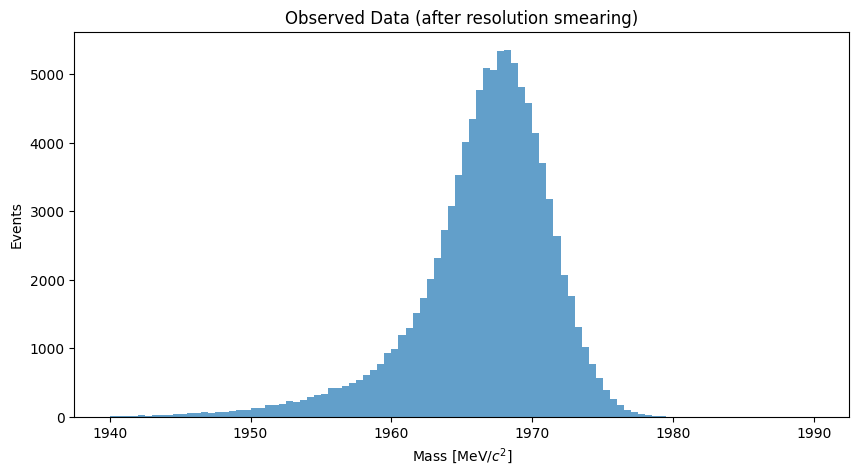

Observed events: 99827


In [3]:
# True parameters for resolution
true_resolution = 3.0  # MeV resolution
true_mass_offset = 0.5  # Small mass calibration offset

# Generate observed data by smearing the simulation
observed_data = sim_data + np.random.normal(true_mass_offset, true_resolution, len(sim_data))
observed_data = observed_data[(observed_data > 1940) & (observed_data < 1990)]

plt.figure(figsize=(10, 5))
plt.hist(observed_data, bins=100, range=(1940, 1990), alpha=0.7)
plt.xlabel('Mass [MeV/$c^2$]')
plt.ylabel('Events')
plt.title('Observed Data (after resolution smearing)')
plt.show()

print(f"Observed events: {len(observed_data)}")

## Build the Convolution Model

We'll convolve the simulated distribution with a Gaussian resolution function.

In [4]:
# Parameters to fit
mu = fl.Param(1960)('mu_offset')  # Mass offset
sigma = fl.Param.positive('sigma')(2)  # Resolution

# Build convolution model using the simulation histogram
conv_model = fl.Param.positive('N') * fl.convolve(
    d_x=sim_centers,      # Bin centers from simulation
    c=sim_counts,         # Bin counts from simulation
    mass_mother=1968,
    mu=mu,
    sigma=sigma
)

print(f"Model parameters: {[p.name for p in conv_model.params]}")

Model parameters: ['N', 'sigma', 'mu_offset']


In [5]:
conv_model

N=1 * ((add_reduce(indecise([0.0001101, 0.0001902, ..., 0, 0], range(0, 80)) * (1 / (sigma=2 * 2.5066282746310002) * exp(-0.5 * ((INPUT + 1968 - mu_offset=1960 - indecise([1940, 1941, ..., 1979, 1980], range(0, 80))) / sigma=2) ** 2)), index=range(0, 80))) / ((indecise(INPUT, 1) - indecise(INPUT, 0)) * sum(add_reduce(indecise([0.0001101, 0.0001902, ..., 0, 0], range(0, 80)) * (1 / (sigma=2 * 2.5066282746310002) * exp(-0.5 * ((INPUT + 1968 - mu_offset=1960 - indecise([1940, 1941, ..., 1979, 1980], range(0, 80))) / sigma=2) ** 2)), index=range(0, 80)))))

## Fit the Convolution Model

In [6]:
# Create cost function (binned chi2)
cost = fl.Cost.chi2(observed_data, bins=100, range=(1940, 1990), zero_method='absolute')

# Fit
result = fl.fit(conv_model | cost)
result

<FitResult fval=74.988, success=True>
N: 9.975e+04 ± 3.2e+02
sigma: 2.989 ± 0.01
mu_offset: 1969 ± 0.013

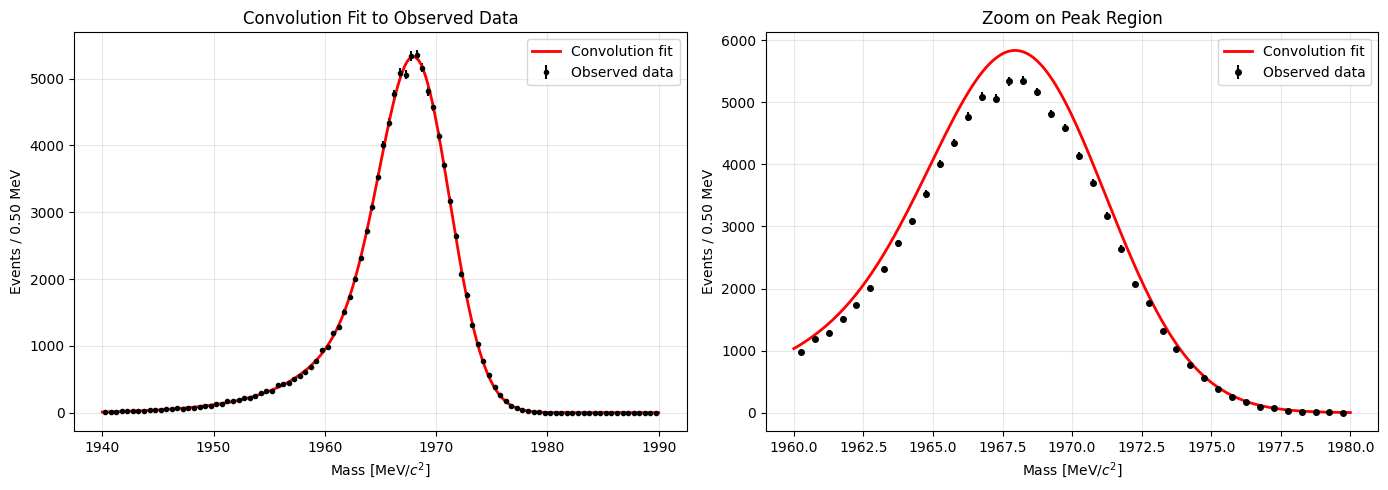

In [14]:
# Plot results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Get histogram for plotting
obs_counts, obs_edges = np.histogram(observed_data, bins=100, range=(1940, 1990))
obs_centers = 0.5 * (obs_edges[1:] + obs_edges[:-1])
bin_width = obs_edges[1] - obs_edges[0]

# Left: Full range
ax = axes[0]
ax.errorbar(obs_centers, obs_counts, yerr=np.sqrt(np.maximum(obs_counts, 1)), 
            fmt='o', markersize=3, color='black', label='Observed data')

x_plot = np.linspace(1940, 1990, 500)
ax.plot(x_plot, conv_model(x_plot) * bin_width, 'r-', linewidth=2, label='Convolution fit')

ax.set_xlabel('Mass [MeV/$c^2$]')
ax.set_ylabel(f'Events / {bin_width:.2f} MeV')
ax.set_title('Convolution Fit to Observed Data')
ax.legend()
ax.grid(True, alpha=0.3)

# Right: Zoom on peak
ax = axes[1]
mask = (obs_centers > 1960) & (obs_centers < 1980)
ax.errorbar(obs_centers[mask], obs_counts[mask], yerr=np.sqrt(np.maximum(obs_counts[mask], 1)), 
            fmt='o', markersize=4, color='black', label='Observed data')

x_zoom = np.linspace(1960, 1980, 300)
ax.plot(x_zoom, conv_model(x_zoom) * bin_width, 'r-', linewidth=2, label='Convolution fit')

ax.set_xlabel('Mass [MeV/$c^2$]')
ax.set_ylabel(f'Events / {bin_width:.2f} MeV')
ax.set_title('Zoom on Peak Region')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
print("=== Fit Results ===")
print(f"\nTrue resolution: {true_resolution:.2f} MeV")
print(f"Fitted resolution: {sigma.value:.2f} +/- {sigma.error:.2f} MeV")
print(f"\nTrue mass offset: {true_mass_offset:.2f} MeV")
print(f"Fitted mass offset: {mu.value:.2f} +/- {mu.error:.2f} MeV")
print(f"\nFitted mother mass: {mass_mother.value:.2f} +/- {mass_mother.error:.2f} MeV")

## Understanding the Index and Reduction

Let's break down how the convolution works internally.

In [ ]:
# The index parameter stores a range
n = fl.index(len(sim_counts))
print(f"Index parameter: {n}")
print(f"Range: 0 to {len(sim_counts)-1}")

# indecise creates a model that selects the nth element
weights = fl.indecise(fl.const(sim_counts), n)
centers_model = fl.indecise(fl.const(sim_centers), n)

print(f"\nWeights model: {weights}")
print(f"Centers model: {centers_model}")

In [ ]:
# The Reduction sums over the index
# For each x value, it computes: sum_n(counts[n] * gaussian(x - centers[n]))

sigma_demo = fl.Param.positive('sigma')(3)
gaussian_at_n = fl.gaussian(mu=centers_model, sigma=sigma_demo)
weighted = weights * gaussian_at_n

# This creates the sum over n
convolved = fl.Reduction(weighted, n, operator.add)
print(f"Reduction: {convolved}")